# TZ Gaming: Optimal Targeting of Mobile Ads

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 200

In [2]:
# loading data
tz_gaming = pd.read_pickle("data/tz_gaming.pkl")

In [3]:
tz_gaming.head()

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,ctrua,imput,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,id
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,0.000000,25,0,0.000000,71,1,1.408451,-1.207066,0.003961,id247135
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,0.000000,7,0,0.000000,67312,1069,1.588127,0.277429,0.003961,id245079
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,6.578947,94,0,0.000000,331,1,0.302115,1.084441,0.003961,id927245
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,0.000000,19,0,0.000000,71114,1001,1.407599,-2.345698,0.018965,id922188
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,0.689655,329,4,1.215805,183852,2317,1.260253,0.429125,0.003961,id355833


In [4]:
# see data description
rsm.describe(tz_gaming)

### TZ Gaming: Optimal Targeting of Mobile Ads

Each row in the `tz_gaming` dataset represents an impression. For each row (impression), we have data on 21 variables. All explanatory variables are created by Vneta based on one month tracking history of users, apps, and ads. The available variables are described in below. 

* _training_ -- Dummy variable that splits the dataset into a training ("train") and a test ("test") set
* _inum_ -- Impression number
* _click_ -- Click indicator for the TZ ad served in the impression. Equals "yes" if the ad was clicked and "no" otherwise
* _time_ -- The hour of the day in which the impression occurred (1-24). For example, "2" indicates the impression occurred between 1 am and 2 am
* _time\_fct_ -- Same as _time_ but the is coded as categorical 
* _app_ -- The app in which the impression was shown. Ranges from 1 to 49
* _mobile\_os_ -- Customer's mobile OS
* _impup_ -- Number of past impressions the user has seen in the app
* _clup_ -- Number of past impressions the user has clicked on in the app
* _ctrup_ -- Past CTR (Click-Through Rate) (x 100) for the user in the app
* _impua_ -- Number of past impressions of the TZ ad that the user has seen across all apps
* _clua_ -- Number of past impressions of the TZ ad that the user has clicked on across all apps
* _ctrua_ -- Past CTR (x 100) of the TZ ad by the user across all apps
* _imput_ -- Number of past impressions the user has seen within in the hour
* _clut_ -- Number of past impressions the user has clicked on in the hour
* _ctrut_ -- Past CTR (x 100) of the user in the hour
* _imppat_ -- Number of past impressions that showed the TZ ad in the app in the hour
* _clpat_ -- Number of past clicks the TZ ad has received in the app in the hour
* _ctrpat_ -- Past CTR (x 100) of the TZ ad in the app in the hour
* _rnd_ -- Simulated data from a normal distribution with mean 0 and a standard deviation of 1
* _pred\_vneta_ -- Predicted probability of click per impressions generated by Vneta's proprietary machine learning algorithm
* id -- Anonymized user ID

Note that there is a clear relationship between the impressions, clicks, and ctr variables within a strata. Specifically: 

* ctrup = clup/impup
* ctru = clu/impu
* ctrut = clut/imput
* ctrpat = clpat/impat

The last three letters of a feature indicate the sources of variation in a variable:

* u — denotes user
* t — denotes time
* p — denotes app
* a — denotes ad 



In [5]:
#一種是impression
#一種是click

## Part I: Logistic regression

a. Estimate a logistic regression model with the following variables `time_fct app mobile_os impua clua ctrua` as the explanatory variables (features) and `click_yes` as the response variable (target)

> Note: Use only the rows that are labeled `train` in the `training` variable

In [6]:
tz_gaming["click_yes"] = rsm.ifelse(tz_gaming.click == "yes", 1, 0)

In [7]:
# Logistic regression via statsmodel (using the formula API)
lr = smf.glm(
    formula="click_yes ~ time_fct + app + mobile_os + impua + clua + ctrua",
    family=Binomial(link=logit()),
    data=tz_gaming[tz_gaming['training']=='train']
).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87458
Model Family:                Binomial   Df Model:                           76
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3946.1
Date:                Fri, 04 Feb 2022   Deviance:                       7892.1
Time:                        06:02:05   Pearson chi2:                 1.60e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.5282      0.197    -17.936      0.000      -3.914      -3.143
time_fct[T.2]         -0.4741      0.321     -1.478      0.139      -1.103       0.155
time_fct[T.3]         -0.3317      0.454     -0.730      0.466      -1.222       0.559
time_fct[T.4]        -23.5430    4.2e+04     -0.001      1.000   -8.24e+04    8.23e+04
time_fct[T.5]        -23.7205   5.52e+04     -0.000      1.000   -1.08e+05    1.08e+05
time_fct[T.6]         -1.0516      1.021     -1.030      0.303      -3.053       0.950
time_fct[T.7]          0.1997      0.426      0.468      0.640      -0.636       1.036
time_fct[T.8]          0.0992      0.296      0.335      0.737      -0.481       0.679
time_fct[T.9]          0.0289      0.287      0.101      0.920      -0.534       0.592
time_fct[T.10]        -0.1866      0.295     -0.633      0.527      -0.764       0.391
time_fct[T.11]        -0.4515      0.276     -1.635      0.102      -0.993       0.090
time_fct[T.12]        -0.1351      0.280     -0.483      0.629      -0.683       0.413
time_fct[T.13]        -0.5281      0.290     -1.823      0.068      -1.096       0.040
time_fct[T.14]         0.0944      0.225      0.419      0.675      -0.347       0.536
time_fct[T.15]        -0.0140      0.225     -0.062      0.951      -0.455       0.428
time_fct[T.16]         0.0453      0.233      0.195      0.846      -0.411       0.502
time_fct[T.17]         0.0138      0.250      0.055      0.956      -0.477       0.504
time_fct[T.18]         0.0595      0.247      0.241      0.809      -0.424       0.543
time_fct[T.19]         0.2500      0.233      1.072      0.284      -0.207       0.707
time_fct[T.20]         0.2019      0.231      0.873      0.382      -0.251       0.655
time_fct[T.21]        -0.1422      0.244     -0.584      0.559      -0.620       0.335
time_fct[T.22]        -0.0302      0.238     -0.127      0.899      -0.496       0.436
time_fct[T.23]         0.0428      0.238      0.180      0.857      -0.424       0.509
time_fct[T.24]         0.0941      0.229      0.410      0.682      -0.356       0.544
app[T.app2]           -2.0905      0.229     -9.127      0.000      -2.539      -1.642
app[T.app3]           -1.6937      1.003     -1.689      0.091      -3.659       0.272
app[T.app4]           -0.9601      0.321     -2.988      0.003      -1.590      -0.330
app[T.app5]           -1.2644      1.005     -1.258      0.208      -3.234       0.705
app[T.app6]           -0.4288      0.175     -2.457      0.014      -0.771      -0.087
app[T.app7]           -0.5169      1.007     -0.513      0.608      -2.491       1.458
app[T.app8]          -24.3740   7.17e+04     -0.000      1.000   -1.41e+05     1.4e+05
app[T.app9]           -0.2899      0.236     -1.227      0.220      -0.753       0.173
app[T.app10]         -23.8906   6.71e+

b. Summarize and interpret the logistic regression results. Provide an interpretation of the odds-ratios estimated for the explanatory variables `mobile_os`, `impua`, `clua`, and `ctrua` and an evaluation of the model as a whole. Which of these explanatory variables are statistically significant? Which variables seem to be most "important"?

> Hint: The Chi-square test for a logistic regression model is equivalent to an F-test for a linear regression model

In [8]:
# discuss and add any code need to calculate additional statistics
# you may need (e.g., rsm.or_ci(lr)[71:] and rsm.model_fit(lr))

rsm.or_ci(lr)

,index,OR,OR%,2.5%,97.5%,p.values,
1,time_fct[T.2],0.622,-37.8%,0.332,1.167,0.139,
2,time_fct[T.3],0.718,-28.2%,0.295,1.749,0.466,
3,time_fct[T.4],0.000,-100.0%,0.000,inf,1.0,
4,time_fct[T.5],0.000,-100.0%,0.000,inf,1.0,
5,time_fct[T.6],0.349,-65.1%,0.047,2.586,0.303,
...,...,...,...,...,...,...,...
72,mobile_os[T.ios],0.450,-55.0%,0.387,0.523,< .001,***
73,mobile_os[T.other],0.719,-28.1%,0.502,1.029,0.072,.
74,impua,0.979,-2.1%,0.975,0.982,< .001,***
75,clua,1.295,29.5%,1.156,1.451,< .001,***


In [9]:
print(rsm.model_fit(lr))


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 159784.981 df(76), p.value < 0.001 
Nr obs: 87,535

None


1. The p value for mobile_os, impua, clua, ctrua are less than 0.05, which means that the coefficient is statistically significantly different from 0 (the variables have impact on the model).

2. The odds ratio for mobile_os, impua, clua, and ctrua are 0.45, 0.979, 1.295 and 1.022 (statistically significantly different from 1), which means that the variables have effects on the response variable. 

odds ratio `mobile_os`: 0.45, which means that the odds of click increase by a factor of 0.45.
odds ratio `impua`: 0.979, , which means that the odds of click increase by a factor of 0.979.
odds ratio `clua`: 1.295, which means that the odds of click increase by a factor of 1.295.
odds ratio `ctrua`: 1.022, which means that the odds of click increase by a factor of 1.022.

`clua` has the largest odds ratio, which means that among for of the above variables, it has the the greatest impact to the model (most important).



3. To measure the overall model performance, we can look at the Chi-squared statistic and its associated p value. The p value is less than 0.05, thus we `reject null hypothesis that all coefficients are equal to zero and that all Odds-ratios are equal to 1`. (If a logistic regression model has a p.value for the Chi-squared statistics that is larger than 0.05, the model is useless.)



c. Predict the probability of a click

The estimated logistic regression model can predict the probability of `click_yes == 1`. Create a new variable `pred_logit` with the predicted click-through probabilities linked to each impression. Make sure to generate predictions for all rows in the training and test data.

In [10]:
tz_gaming["pred_logit"] = rsm.predict_ci(fitted=lr, df=tz_gaming).iloc[:,0]
# tz_gaming["pred_logit"] = lr.predict(tz_gaming)
tz_gaming.head()


,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,id,click_yes,pred_logit
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,0,0.000000,71,1,1.408451,-1.207066,0.003961,id247135,0,3.382977e-13
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,0,0.000000,67312,1069,1.588127,0.277429,0.003961,id245079,0,1.156355e-02
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,0,0.000000,331,1,0.302115,1.084441,0.003961,id927245,0,2.655311e-03
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,0,0.000000,71114,1001,1.407599,-2.345698,0.018965,id922188,0,1.349420e-02
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,4,1.215805,183852,2317,1.260253,0.429125,0.003961,id355833,0,1.868222e-03


d. Re-estimate the logistic regression after standardizing the numeric explanatory variables (see sample code below). What is the interpretation of the standardized odds-ratios for the explanatory variables? Which variables seem to be most important now and how does this compare to your conclusions from (b) above? Has the model fit changed after you standardized the variables?

> Tip: Use `or_plot` from the `pyrsm` packages to visualize the (standardized) odds-ratios.

> Tip: Check the mean, std, min, and max for the transformed variables

In [11]:
# select variables to standardize
to_std = tz_gaming.loc[:, "impup":"ctrpat"].columns

# scale numeric variables by (x - mean(x)) / sd(x)
tz_std = tz_gaming.copy()
tz_std[to_std] = rsm.scale_df(
    tz_gaming[to_std], sf=1, train=tz_gaming.training == "train"
)

In [12]:
# tz_std.head()

In [13]:
# estimate your model and assign the fitted model to lr_std
lr_std = smf.glm(
    formula="click_yes ~ time_fct + app + mobile_os + impua + clua + ctrua",
    family=Binomial(link=logit()),
    data=tz_std[tz_std['training']=='train']
).fit()
lr_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87458
Model Family:                Binomial   Df Model:                           76
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3946.1
Date:                Fri, 04 Feb 2022   Deviance:                       7892.1
Time:                        06:02:13   Pearson chi2:                 1.60e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.3613      0.197    -22.110      0.000      -4.748      -3.975
time_fct[T.2]         -0.4741      0.321     -1.478      0.139      -1.103       0.155
time_fct[T.3]         -0.3317      0.454     -0.730      0.466      -1.222       0.559
time_fct[T.4]        -23.5430    4.2e+04     -0.001      1.000   -8.24e+04    8.23e+04
time_fct[T.5]        -23.7205   5.52e+04     -0.000      1.000   -1.08e+05    1.08e+05
time_fct[T.6]         -1.0516      1.021     -1.030      0.303      -3.053       0.950
time_fct[T.7]          0.1997      0.426      0.468      0.640      -0.636       1.036
time_fct[T.8]          0.0992      0.296      0.335      0.737      -0.481       0.679
time_fct[T.9]          0.0289      0.287      0.101      0.920      -0.534       0.592
time_fct[T.10]        -0.1866      0.295     -0.633      0.527      -0.764       0.391
time_fct[T.11]        -0.4515      0.276     -1.635      0.102      -0.993       0.090
time_fct[T.12]        -0.1351      0.280     -0.483      0.629      -0.683       0.413
time_fct[T.13]        -0.5281      0.290     -1.823      0.068      -1.096       0.040
time_fct[T.14]         0.0944      0.225      0.419      0.675      -0.347       0.536
time_fct[T.15]        -0.0140      0.225     -0.062      0.951      -0.455       0.428
time_fct[T.16]         0.0453      0.233      0.195      0.846      -0.411       0.502
time_fct[T.17]         0.0138      0.250      0.055      0.956      -0.477       0.504
time_fct[T.18]         0.0595      0.247      0.241      0.809      -0.424       0.543
time_fct[T.19]         0.2500      0.233      1.072      0.284      -0.207       0.707
time_fct[T.20]         0.2019      0.231      0.873      0.382      -0.251       0.655
time_fct[T.21]        -0.1422      0.244     -0.584      0.559      -0.620       0.335
time_fct[T.22]        -0.0302      0.238     -0.127      0.899      -0.496       0.436
time_fct[T.23]         0.0428      0.238      0.180      0.857      -0.424       0.509
time_fct[T.24]         0.0941      0.229      0.410      0.682      -0.356       0.544
app[T.app2]           -2.0905      0.229     -9.127      0.000      -2.539      -1.642
app[T.app3]           -1.6937      1.003     -1.689      0.091      -3.659       0.272
app[T.app4]           -0.9601      0.321     -2.988      0.003      -1.590      -0.330
app[T.app5]           -1.2644      1.005     -1.258      0.208      -3.234       0.705
app[T.app6]           -0.4288      0.175     -2.457      0.014      -0.771      -0.087
app[T.app7]           -0.5169      1.007     -0.513      0.608      -2.491       1.458
app[T.app8]          -24.3740   7.17e+04     -0.000      1.000   -1.41e+05     1.4e+05
app[T.app9]           -0.2899      0.236     -1.227      0.220      -0.753       0.173
app[T.app10]         -23.8906   6.71e+

In [14]:
tz_std.describe()

,time,impup,clup,ctrup,impua,clua,ctrua,imput,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,click_yes,pred_logit
count,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,1.154880e+05
mean,15.708203,0.000928,0.007255,0.009337,0.017570,0.010810,0.003147,-0.000646,0.002431,0.001669,0.040182,0.035951,0.010373,0.003138,0.008859,0.009049,8.829781e-03
std,6.199491,1.002776,0.992606,1.040919,1.032626,1.016477,1.005684,0.977142,1.003530,1.003459,1.034921,1.031238,1.000947,0.998950,0.012537,0.094693,1.290467e-02
min,1.000000,-0.567816,-0.496443,-0.258456,-0.628822,-0.328254,-0.176809,-0.511386,-0.328451,-0.185081,-0.887617,-0.770202,-1.276072,-4.653724,0.003961,0.000000,3.092070e-31
25%,13.000000,-0.483849,-0.496443,-0.258456,-0.509509,-0.328254,-0.176809,-0.423833,-0.328451,-0.185081,-0.800071,-0.749817,-0.986955,-0.670542,0.003961,0.000000,1.451737e-03
50%,16.000000,-0.267723,-0.359199,-0.202487,-0.270882,-0.328254,-0.176809,-0.248728,-0.328451,-0.185081,-0.348307,-0.585278,0.274560,0.005599,0.003961,0.000000,5.473010e-03
75%,21.000000,0.160554,0.189780,-0.053811,0.191457,-0.328254,-0.176809,0.106955,-0.328451,-0.185081,0.511829,0.687354,0.636642,0.673514,0.003961,0.000000,1.190124e-02
max,24.000000,22.296324,49.186077,30.335937,23.681251,26.846906,17.739926,45.026903,46.322200,25.064466,2.889797,2.603582,10.371197,3.906469,0.050679,1.000000,4.121223e-01


In [15]:
tz_gaming.describe()

,time,impup,clup,ctrup,impua,clua,ctrua,imput,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,click_yes,pred_logit
count,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,1.154880e+05
mean,15.708203,1144.718984,3.670078,0.875299,43.340849,0.212109,1.004398,93.336225,0.326268,0.739615,45157.261932,553.638447,0.946717,0.003138,0.008859,0.009049,8.829781e-03
std,6.199491,2018.302408,7.232392,3.402320,69.237956,0.635879,5.613101,178.570152,0.989534,3.974166,50371.069034,708.219057,0.736615,0.998950,0.012537,0.094693,1.290467e-02
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.653724,0.003961,0.000000,3.092070e-31
25%,13.000000,169.000000,0.000000,0.000000,8.000000,0.000000,0.000000,16.000000,0.000000,0.000000,4261.000000,14.000000,0.212766,-0.670542,0.003961,0.000000,1.451737e-03
50%,16.000000,604.000000,1.000000,0.182938,24.000000,0.000000,0.000000,48.000000,0.000000,0.000000,26249.000000,127.000000,1.141137,0.005599,0.003961,0.000000,5.473010e-03
75%,21.000000,1466.000000,5.000000,0.668896,55.000000,0.000000,0.000000,113.000000,0.000000,0.000000,68113.000000,1001.000000,1.407599,0.673514,0.003961,0.000000,1.190124e-02
max,24.000000,46019.000000,362.000000,100.000000,1630.000000,17.000000,100.000000,8322.000000,46.000000,100.000000,183852.000000,2317.000000,8.571429,3.906469,0.050679,1.000000,4.121223e-01


In [16]:
rsm.or_ci(lr_std)

,index,OR,OR%,2.5%,97.5%,p.values,
1,time_fct[T.2],0.622,-37.8%,0.332,1.167,0.139,
2,time_fct[T.3],0.718,-28.2%,0.295,1.749,0.466,
3,time_fct[T.4],0.000,-100.0%,0.000,inf,1.0,
4,time_fct[T.5],0.000,-100.0%,0.000,inf,1.0,
5,time_fct[T.6],0.349,-65.1%,0.047,2.586,0.303,
...,...,...,...,...,...,...,...
72,mobile_os[T.ios],0.450,-55.0%,0.387,0.523,< .001,***
73,mobile_os[T.other],0.719,-28.1%,0.502,1.029,0.072,.
74,impua,0.236,-76.4%,0.184,0.303,< .001,***
75,clua,1.176,17.6%,1.095,1.262,< .001,***


In [17]:
print(rsm.model_fit(lr_std))


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 159784.981 df(76), p.value < 0.001 
Nr obs: 87,535

None


In [18]:
tz_std.columns

Index(['training', 'inum', 'click', 'time', 'time_fct', 'app', 'mobile_os',
       'impup', 'clup', 'ctrup', 'impua', 'clua', 'ctrua', 'imput', 'clut',
       'ctrut', 'imppat', 'clpat', 'ctrpat', 'rnd', 'pred_vneta', 'id',
       'click_yes', 'pred_logit'],
      dtype='object')

<AxesSubplot:xlabel='Odds-ratio'>

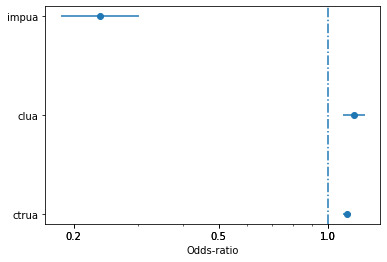

In [19]:
rsm.or_plot(fitted=lr_std, excl=['training', 'inum', 'click', 'time', 'time_fct', 'app', 'mobile_os',
       'rnd', 'pred_vneta', 'id', 'click_yes', 'pred_logit', 'pred_rnd'])

1. After standardizing the variables, the p value now for mobile_os, impua, clua, ctrua are still less than 0.05, which means that the coefficients are statistically significantly different from 0 (the variables have impact on the model). 

2.  The odds ratio for mobile_os, impua, clua, and ctrua are 0.45, 0.236, 1.176 and 1.127 (statistically significantly different from 1), which means that the variables have effects on the response variable. 

odds ratio `mobile_os`: 0.45, which means that the odds of click increase by a factor of 0.45.
odds ratio `impua`: 0.236, , which means that the odds of click increase by a factor of 0.236. (The odds ratio decrease from 0.979 to 0.236)
odds ratio `clua`: 1.176, which means that the odds of click increase by a factor of 1.176. (The odds ratio decrease from 1.295 to 1.176)
odds ratio `ctrua`: 1.127, which means that the odds of click increase by a factor of 1.127. (The odds ratio increase from 1.022 to 1.127)

`clua` still has the largest odds ratio, which means that among the above variables, it has the the greatest impact to the model (most important). However, the odds ratio decreases compared with the model without standardizing the variables. 

3. The Chi-squared statistic and its associated p value is still less than 0.05, which means that we still `reject null hypothesis that all coefficients are equal to zero and that all Odds-ratios are equal to 1`

4. After standardization, the mean, standard deviation for impua, clua, ctrua are similar (around 0, 1, they were widely different from each other before standardization). This means that the effect to the model of each variable is more comparable.

e. Estimate a logistic regression with `click_yes` as the response variable and `rnd` as the only explanatory variable. As before, the model should be estimated on the training sample (i.e., `training == 'train'`). Create a new variable `pred_rnd` with the predicted click-through probabilities.

In [20]:
# add your code
lr_rnd = smf.glm(
    formula="click_yes ~ rnd",
    family=Binomial(link=logit()),
    data=tz_gaming[tz_gaming['training']=='train']
).fit()
print(lr_rnd.summary())



tz_gaming["pred_rnd"] = rsm.predict_ci(fitted=lr_rnd, df=tz_gaming).iloc[:,0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87533
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4429.7
Date:                Fri, 04 Feb 2022   Deviance:                       8859.5
Time:                        06:02:14   Pearson chi2:                 8.75e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7199      0.036   -130.657      0.0

## Part II: Understanding Multicollinearity

a. Estimate a logistic regression model with `click_yes` as the response variable and `imppat`, `clpat`, and
`ctrpat` as the only explanatory variable. Make sure to standardize the explanatory variables before estimation (see example code below). What is the interpretation of the standardized odds-ratios for the explanatory variables?

In [21]:
# select variables to standardize
to_std = tz_gaming.loc[:, "impup":"ctrpat"].columns
# scale numeric variables by (x - mean(x)) / sd(x)
tz_std = tz_gaming.copy()
tz_std[to_std] = rsm.scale_df(
    tz_gaming[to_std], sf=1, train=tz_gaming.training == "train"
)

In [22]:
# add your code to estimate the model
lr_mc1 = smf.glm(formula='click_yes ~ imppat + clpat + ctrpat',
                family=Binomial(link=logit()),
                data=tz_std[tz_std['training']=='train']).fit()
lr_mc1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87531
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4273.1
Date:                Fri, 04 Feb 2022   Deviance:                       8546.2
Time:                        06:02:15   Pearson chi2:                 8.16e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9146      0.043   -114.228      0.000      -4.999      -4.830
imppat        -1.0050      0.209     -4.802      0.000      -1.415      -0.595
clpat          1.2293      0.215      5.713      0.000       0.808       1.651
ctrpat         0.3527      0.025     13.933      0.000       0.303       0.402
==============================================================================
"""

In [23]:
tz_std.describe()

,time,impup,clup,ctrup,impua,clua,ctrua,imput,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,click_yes,pred_logit,pred_rnd
count,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,115488.000000,1.154880e+05,115488.000000
mean,15.708203,0.000928,0.007255,0.009337,0.017570,0.010810,0.003147,-0.000646,0.002431,0.001669,0.040182,0.035951,0.010373,0.003138,0.008859,0.009049,8.829781e-03,0.008842
std,6.199491,1.002776,0.992606,1.040919,1.032626,1.016477,1.005684,0.977142,1.003530,1.003459,1.034921,1.031238,1.000947,0.998950,0.012537,0.094693,1.290467e-02,0.000312
min,1.000000,-0.567816,-0.496443,-0.258456,-0.628822,-0.328254,-0.176809,-0.511386,-0.328451,-0.185081,-0.887617,-0.770202,-1.276072,-4.653724,0.003961,0.000000,3.092070e-31,0.007697
25%,13.000000,-0.483849,-0.496443,-0.258456,-0.509509,-0.328254,-0.176809,-0.423833,-0.328451,-0.185081,-0.800071,-0.749817,-0.986955,-0.670542,0.003961,0.000000,1.451737e-03,0.008629
50%,16.000000,-0.267723,-0.359199,-0.202487,-0.270882,-0.328254,-0.176809,-0.248728,-0.328451,-0.185081,-0.348307,-0.585278,0.274560,0.005599,0.003961,0.000000,5.473010e-03,0.008835
75%,21.000000,0.160554,0.189780,-0.053811,0.191457,-0.328254,-0.176809,0.106955,-0.328451,-0.185081,0.511829,0.687354,0.636642,0.673514,0.003961,0.000000,1.190124e-02,0.009049
max,24.000000,22.296324,49.186077,30.335937,23.681251,26.846906,17.739926,45.026903,46.322200,25.064466,2.889797,2.603582,10.371197,3.906469,0.050679,1.000000,4.121223e-01,0.010415


<AxesSubplot:xlabel='Odds-ratio'>

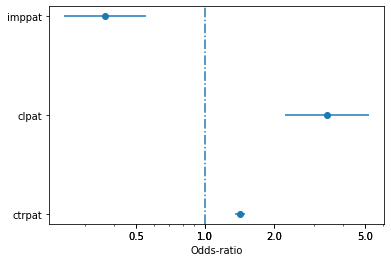

In [24]:
rsm.or_plot(fitted=lr_mc1)

In [25]:
rsm.or_ci(lr_mc1)

,index,OR,OR%,2.5%,97.5%,p.values,
1,imppat,0.366,-63.4%,0.243,0.552,< .001,***
2,clpat,3.419,241.9%,2.242,5.212,< .001,***
3,ctrpat,1.423,42.3%,1.354,1.495,< .001,***


... discuss the results here ...

The odds ratio for imppat, clpat, ctrpat, are 0.366, 3.419, 1.423 (statistically significantly different from 1), which means that the variables have effects on the response variable. 

odds ratio `imppat`: 0.366, which means that the odds of click increase by a factor of 0.366.
odds ratio `clpat`: 3.419, , which means that the odds of click increase by a factor of 3.419.
odds ratio `ctrpat`: 1.423, which means that the odds of click increase by a factor of 1.423. 

`clpat` has the largest odds ratio, which means that among for of the above variables, it has the the greatest impact to the model (most important).


b. Some of the variables in the dataset are highly correlated with each other. In particular, imppat
and clpat have a positive correlation of 0.97. Discuss the implications of this (very) high level of
collinearity and also different approaches to deal with it. What are the implications for the model and
the interpretation of the estimated (standardized) coefficients? As part of your answer, discuss the
change in the estimated (standardized) odds-ratios for imppat when you remove clpat from the model.

In [26]:
# insert your answer here
# hint: review the help for the `vif` function in the pyrsm function

VIF estimates how much the variance of a regression coefficient is inflated due to multicollinearity in the model. The more VIF increases, the less reliable the regression results is. VIF above 5 indicates high correlation and is cause for concern. 
In model `lr_mc1`, VIF for clpat and imppat are both greater than 5, meaning that they can be predicted by other independent variables in the dataset. To deal with high collinearity, one thing we can do is remove one of the variable which is highly correlated with other variables. Another choice is to run stepwise regression to decide which variable to remove. 


The odds ratio for imppat, clpat, ctrpat, are 0.366, 3.419, 1.423 (statistically significantly different from 1), which means that the variables have effects on the response variable. 

odds ratio `imppat`: 0.366, which means that the odds of click increase by a factor of 0.366.
odds ratio `clpat`: 3.419, , which means that the odds of click increase by a factor of 3.419.
odds ratio `ctrpat`: 1.423, which means that the odds of click increase by a factor of 1.423. 



After removing clpat from the model, in `lr_mc1`, the VIF for imppat and ctrpat are both small, which means that multicollinearity is not a concern. 

The odds ratio for imppat, ctrpat, are 1.188, 1.499, meaning that the odds of click increase by a factor of 1.188 (or 18.8%) and 1.499 (or 49.9%), which is greather than the result from `lr_mc1`.



In [27]:
lr_mc2 = smf.glm(
    formula='click_yes ~ imppat + ctrpat',
                family=Binomial(link=logit()),
                data=tz_std[tz_std['training']=='train']).fit()
lr_mc2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87532
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4290.9
Date:                Fri, 04 Feb 2022   Deviance:                       8581.8
Time:                        06:02:15   Pearson chi2:                 8.16e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8594      0.040   -121.262      0.000      -4.938      -4.781
imppat         0.1725      0.032      5.460      0.000       0.111       0.234
ctrpat         0.4045      0.022     18.422      0.000       0.361       0.448
==============================================================================
"""

In [28]:
rsm.or_ci(lr_mc2)

,index,OR,OR%,2.5%,97.5%,p.values,
1,imppat,1.188,18.8%,1.117,1.264,< .001,***
2,ctrpat,1.499,49.9%,1.435,1.564,< .001,***


In [29]:
rsm.vif(lr_mc1)

,variable,vif,Rsq
0,clpat,26.242,0.962
1,imppat,23.467,0.957
2,ctrpat,1.668,0.400


In [30]:
rsm.vif(lr_mc2)

,variable,vif,Rsq
0,imppat,1.134,0.118
1,ctrpat,1.134,0.118


c. Estimate another logistic regression model with `click_yes` as the response variable and `time_fct`,
`app`, `imppat`, `clpat`, and `ctrpat` as the explanatory variable. Why are the odds ratios for `imppat`,
`clpat`, and `ctrpat` different in the two models? Please be specific and investigate beyond simply
stating the statistical problem.

In [31]:
# insert your code here
lr_mc3 = smf.glm(
    formula='click_yes ~ time_fct + app + imppat + clpat + ctrpat',
                family=Binomial(link=logit()),
                data=tz_std[tz_std['training']=='train']).fit()

lr_mc3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87460
Model Family:                Binomial   Df Model:                           74
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4180.6
Date:                Fri, 04 Feb 2022   Deviance:                       8361.3
Time:                        06:02:21   Pearson chi2:                 8.39e+04
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.3871      0.206    -21.281      0.000      -4.791      -3.983
time_fct[T.2]     -0.5316      0.323     -1.644      0.100      -1.166       0.102
time_fct[T.3]     -0.3669      0.461     -0.795      0.426      -1.271       0.537
time_fct[T.4]    -23.8342   4.39e+04     -0.001      1.000   -8.61e+04     8.6e+04
time_fct[T.5]    -23.8601   5.72e+04     -0.000      1.000   -1.12e+05    1.12e+05
time_fct[T.6]     -1.0252      1.027     -0.999      0.318      -3.037       0.987
time_fct[T.7]      0.1986      0.438      0.453      0.650      -0.660       1.057
time_fct[T.8]      0.1270      0.309      0.411      0.681      -0.479       0.733
time_fct[T.9]      0.0606      0.299      0.203      0.839      -0.525       0.646
time_fct[T.10]    -0.1703      0.303     -0.561      0.575      -0.765       0.424
time_fct[T.11]    -0.4512      0.288     -1.565      0.118      -1.016       0.114
time_fct[T.12]    -0.1810      0.292     -0.620      0.535      -0.753       0.391
time_fct[T.13]    -0.6261      0.306     -2.047      0.041      -1.226      -0.026
time_fct[T.14]    -0.0177      0.257     -0.069      0.945      -0.522       0.487
time_fct[T.15]    -0.1738      0.272     -0.639      0.523      -0.707       0.359
time_fct[T.16]    -0.1346      0.279     -0.483      0.629      -0.681       0.412
time_fct[T.17]    -0.1458      0.296     -0.493      0.622      -0.725       0.434
time_fct[T.18]    -0.0595      0.286     -0.208      0.835      -0.619       0.500
time_fct[T.19]     0.1637      0.251      0.651      0.515      -0.329       0.656
time_fct[T.20]     0.1723      0.247      0.698      0.485      -0.311       0.656
time_fct[T.21]    -0.2455      0.261     -0.942      0.346      -0.756       0.265
time_fct[T.22]    -0.0691      0.259     -0.267      0.789      -0.576       0.438
time_fct[T.23]    -0.0066      0.268     -0.025      0.980      -0.533       0.520
time_fct[T.24]     0.1255      0.258      0.486      0.627      -0.380       0.631
app[T.app2]       -1.9965      0.351     -5.681      0.000      -2.685      -1.308
app[T.app3]       -1.6746      1.016     -1.649      0.099      -3.665       0.316
app[T.app4]       -0.7193      0.359     -2.004      0.045      -1.423      -0.016
app[T.app5]       -0.8832      1.011     -0.874      0.382      -2.864       1.098
app[T.app6]        0.0073      0.216      0.034      0.973      -0.416       0.431
app[T.app7]       -0.3460      1.019     -0.340      0.734      -2.343       1.651
app[T.app8]      -24.1102   7.27e+04     -0.000      1.000   -1.43e+05    1.42e+05
app[T.app9]       -0.0672      0.271     -0.248      0.804      -0.599       0.464
app[T.app10]     -24.0211   7.56e+04     -0.000      1.000   -1.48e+05    1.48e+05
app[T.app11]       0.3115      0.752      0.414      0.679      -1.163       1.786
app[T.app12]

In [32]:
rsm.or_ci(lr_mc3)

,index,OR,OR%,2.5%,97.5%,p.values,
1,time_fct[T.2],0.588,-41.2%,0.312,1.108,0.1,
2,time_fct[T.3],0.693,-30.7%,0.280,1.711,0.426,
3,time_fct[T.4],0.000,-100.0%,0.000,inf,1.0,
4,time_fct[T.5],0.000,-100.0%,0.000,inf,1.0,
5,time_fct[T.6],0.359,-64.1%,0.048,2.683,0.318,
...,...,...,...,...,...,...,...
70,app[T.app48],0.000,-100.0%,0.000,inf,1.0,
71,app[T.app49],0.259,-74.1%,0.035,1.911,0.185,
72,imppat,0.604,-39.6%,0.252,1.446,0.258,
73,clpat,1.713,71.3%,0.676,4.338,0.256,


In [33]:
# you may find the code below useful
# the wald test evaluates is a (set of) coefficients
# are equal to 0
lr_mc3.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,452.901,0.000,1
time_fct,26.338,0.285,23
app,89.800,0.000,48
imppat,1.280,0.258,1
clpat,1.288,0.256,1
ctrpat,0.406,0.524,1


 ... insert your answer here ...

Estimate another logistic regression model with click_yes as the response variable and time_fct, app, imppat, clpat, and ctrpat as the explanatory variable. Why are the odds ratios for imppat, clpat, and ctrpat different in the two models? Please be specific and investigate beyond simply stating the statistical problem.

In `lr_mc2`, The odds ratio for imppat, ctrpat, are 1.205, 1.495, meaning that the odds of click increase by a factor of 1.205 (or 20.5%) and 1.495 (or 49.5%), which is greather than the result from `lr_mc1`.


In `lr_mc3`, the odds ratio for imppat, clpat, and ctrpat are 0.592, 1.839, 1.037. The odds ratio for imppat and ctrpat both decrease in this model, which means that their affect to the dependent variable is less in `lr_mc3` compared with `lr_mc2`. This is because when adding other variables to the model, these variables also effect the dependent variable, causing the impact of imppat and ctrpat become weaker.

In model 3, p value for imppat, clpat, and ctrpat are all greater than 0.05, which means that they are not significant. This might due to the fact that we add clpat, an variable which is highly correlated with imppat to the model, resulting to a poorer model performance. 

## Part III: Decile Analysis of Logistic Regression Results (5 points)

a. Assign each impression to a decile based on the predicted probability of click through (i.e., `pred_logit`). Create a new variable `dec_logit` that captures this information. Note: The first decile should have the highest average click-through rate. If that is not the case, make sure to “reverse” the decile numbers (i.e., 10 becomes 1, 9 becomes 2, etc.). Please use the `xtile` function from the _pyrsm_ package to create the deciles (2 points)

In [34]:
# insert your answer here

training = rsm.xtile(tz_gaming[tz_gaming['training']=='train']["pred_logit"], 10, rev=True).tolist()
testing = rsm.xtile(tz_gaming[tz_gaming['training']=='test']["pred_logit"], 10, rev=True).tolist()

tz_gaming["dec_logit"] = training + testing
tz_gaming.head()


,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,imppat,clpat,ctrpat,rnd,pred_vneta,id,click_yes,pred_logit,pred_rnd,dec_logit
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,71,1,1.408451,-1.207066,0.003961,id247135,0,3.382977e-13,0.009222,10
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,67312,1069,1.588127,0.277429,0.003961,id245079,0,1.156355e-02,0.008751,3
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,331,1,0.302115,1.084441,0.003961,id927245,0,2.655311e-03,0.008505,7
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,71114,1001,1.407599,-2.345698,0.018965,id922188,0,1.349420e-02,0.009600,3
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,183852,2317,1.260253,0.429125,0.003961,id355833,0,1.868222e-03,0.008704,8



b. Report the number of impressions, the number of clicks, and the click-through rate for the TZ ad per decile and save this information to a DataFrame. Use the name `df_dec_logit` for the new data frame (2 points)

In [67]:
# insert your answer here
tz_gaming_test = tz_gaming[tz_gaming['training']=='test']
impression = tz_gaming_test.groupby(tz_gaming_test.dec_logit).count() [['impup']].rename(columns={'impup': 'num of impressions'})
click = tz_gaming_test[tz_gaming_test['click_yes']==1].groupby(tz_gaming_test[tz_gaming_test['click_yes']==1].dec_logit).count()[['impup']].rename(columns={'impup': 'num of clicks'})

df_dec_logit = pd.concat([impression, click], axis=1).reset_index()
df_dec_logit['CTR'] = df_dec_logit['num of clicks'] / df_dec_logit['num of impressions']
df_dec_logit

,dec_logit,num of impressions,num of clicks,CTR
0,1,2796,103,0.036838
1,2,2793,48,0.017186
2,3,2788,42,0.015065
3,4,2796,30,0.010730
4,5,2802,15,0.005353
5,6,2796,7,0.002504
6,7,2794,7,0.002505
7,8,2796,3,0.001073
8,9,2796,4,0.001431
9,10,2796,12,0.004292


c. Create a bar chart of click-through rates per decile (i.e., use dec_logit as the x-variable and ctr as the y-variable). Note that the “click through rate” is not the same as the “predicted probability of click.” The click-through rate captures the proportion of impressions in a given group (e.g., in a decile) that actually resulted in a click (1 point)


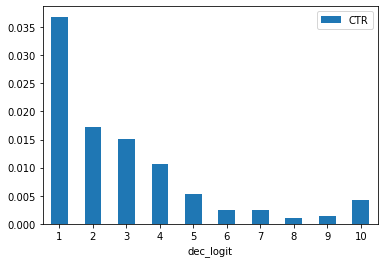

In [36]:
# ... insert your answer here ...
ax = df_dec_logit.plot.bar(x='dec_logit', y='CTR', rot=0)

## Part IV: Lift, Gains, and Profit (15 points)

Use the `df_dec_logit DataFrame` you created in Part III for the following calculations.

> Note: Do NOT use any specialized packages to answer the questions below. Write the python code for the lift, gains, and profit tables from scratch and use seaborn, pandas, or matplotlib for the graphs

a. Write python code to generate a DataFrame with the cumulative proportion of impressions and the cumulative lift for each decile (3 points)

In [69]:
# insert your answer here
#lift = response rate / overall_response_rate
lift_tab = df_dec_logit[['dec_logit']]
lift_tab['cum_prop_impressions'] = (df_dec_logit['num of impressions'].cumsum() / df_dec_logit['num of impressions'].sum())

lift = (df_dec_logit['CTR']/df_dec_logit['CTR'].mean()).tolist()
total = 0
cum_lift = []
for i in range(len(lift)):
    total += lift[i]
    cum_lift.append(total/(i+1))
    
lift_tab['cum_response'] = cum_lift
lift_tab

<ipython-input-69-27c353b83aa0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lift_tab['cum_prop_impressions'] = (df_dec_logit['num of impressions'].cumsum() / df_dec_logit['num of impressions'].sum())
<ipython-input-69-27c353b83aa0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lift_tab['cum_response'] = cum_lift


,dec_logit,cum_prop_impressions,cum_response
0,1,0.100025,3.798706
1,2,0.199943,2.785439
2,3,0.299682,2.374770
3,4,0.399707,2.057682
4,5,0.499946,1.756551
5,6,0.599971,1.506820
6,7,0.699925,1.328467
7,8,0.799950,1.176239
8,9,0.899975,1.061937
9,10,1.000000,1.000000


b. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the cumulative lift per decile. Put cumulative lift on the Y-axis and cumulative proportion of impressions on the X-axis (2 points)

Text(0, 0.5, 'cumulative lift per decile')

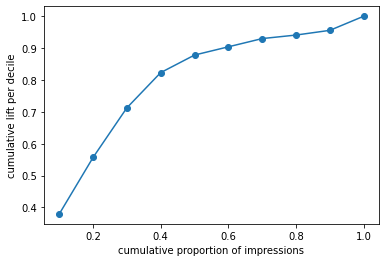

In [38]:
# insert your answer here

plt.plot('cum_prop_impressions', 'cum_lift', data=lift_tab, marker="o")
plt.xlabel("cumulative proportion of impressions")
plt.ylabel("cumulative lift per decile")

c. Write python code to generate a DataFrame with the cumulative proportion of impressions and the cumulative gains for each decile (3 points)

In [39]:
# insert your answer here
gains_tab = df_dec_logit[['dec_logit']]

gains_tab['cum_prop_impressions'] = (df_dec_logit['num of impressions'].cumsum() / df_dec_logit['num of impressions'].sum())
gains_tab['cum_gains'] = (df_dec_logit['num of clicks'].cumsum() / df_dec_logit['num of clicks'].sum()).to_frame().rename(columns={'num of clicks':'cum_gains'})
gains_tab

<ipython-input-39-452aeccb6500>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gains_tab['cum_prop_impressions'] = (df_dec_logit['num of impressions'].cumsum() / df_dec_logit['num of impressions'].sum())
<ipython-input-39-452aeccb6500>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gains_tab['cum_gains'] = (df_dec_logit['num of clicks'].cumsum() / df_dec_logit['num of clicks'].sum()).to_frame().rename(columns={'num of clicks':'cum_gains'})


,dec_logit,cum_prop_impressions,cum_gains
0,1,0.100025,0.380074
1,2,0.199943,0.557196
2,3,0.299682,0.712177
3,4,0.399707,0.822878
4,5,0.499946,0.878229
5,6,0.599971,0.904059
6,7,0.699925,0.929889
7,8,0.799950,0.940959
8,9,0.899975,0.955720
9,10,1.000000,1.000000


d. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the cumulative gains per decile along with a (diagonal) reference line to represent the "no model" scenario. Put cumulative gains on the Y-axis and cumulative proportion of impressions on the X-axis (2 points)

Text(0, 0.5, 'cumulative gains')

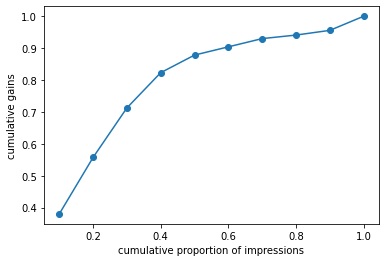

In [40]:
# insert your answer here

plt.plot('cum_prop_impressions', 'cum_gains', data=gains_tab, marker="o")
plt.xlabel("cumulative proportion of impressions")
plt.ylabel("cumulative gains")

e. Write python code to generate a table with the cumulative proportion of impressions and profits for each decile (3 points)

In [41]:
# insert your answer here
profit_tab = df_dec_logit[['dec_logit']]
profit_tab['cum_prop_impressions'] = (df_dec_logit['num of impressions'].cumsum() / df_dec_logit['num of impressions'].sum())
profit_tab['cum_profit'] = ((df_dec_logit['num of clicks']*0.05*25) - (df_dec_logit['num of impressions']*10/1000)).cumsum() #- 50000/len(tz_gaming)*df_dec_logit['num of impressions']
profit_tab

<ipython-input-41-7c8459b2c92f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_tab['cum_prop_impressions'] = (df_dec_logit['num of impressions'].cumsum() / df_dec_logit['num of impressions'].sum())
<ipython-input-41-7c8459b2c92f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_tab['cum_profit'] = ((df_dec_logit['num of clicks']*0.05*25) - (df_dec_logit['num of impressions']*10/1000)).cumsum() #- 50000/len(tz_gaming)*df_dec_logit['num of impressions']


,dec_logit,cum_prop_impressions,cum_profit
0,1,0.100025,100.79
1,2,0.199943,132.86
2,3,0.299682,157.48
3,4,0.399707,167.02
4,5,0.499946,157.75
5,6,0.599971,138.54
6,7,0.699925,119.35
7,8,0.799950,95.14
8,9,0.899975,72.18
9,10,1.000000,59.22


f. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the profits per decile. Put profit on the Y-axis and cumulative proportion of impressions on the X-axis (2 points)

Text(0, 0.5, 'cumulative profit')

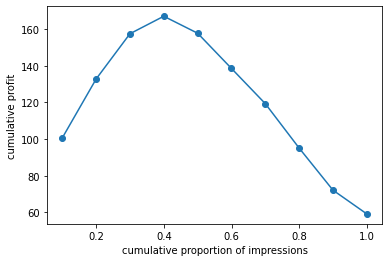

In [42]:
# insert your answer here
plt.plot('cum_prop_impressions', 'cum_profit', data=profit_tab, marker="o")
plt.xlabel("cumulative proportion of impressions")
plt.ylabel("cumulative profit")

## Part V: Confusion matrix (10 points)

a. Create a DataFrame with elements from a "confusion matrix" based on the predictions from the logistic regression model you estimated in Part I (i.e., `pred_logit`). Again, use only data from the test set here (i.e., `training == 'test'`).

Use the financial assumptions mentioned above, and repeated in section VI below, to determine an appropriate cut-off (i.e., break-even). Calculate `accuracy` based on the confusion matrix you created (see <http://lab.rady.ucsd.edu/sawtooth/RBusinessAnalytics/logit_models.html> for an example using R) (2 points)

> Note: Do NOT use any specialized packages to construct the confusion matrix. Write the python code to construct the confusion matrix from scratch

In [43]:
# breakeven = cost / margin (profit)

In [44]:
tz_gaming.head()

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,imppat,clpat,ctrpat,rnd,pred_vneta,id,click_yes,pred_logit,pred_rnd,dec_logit
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,71,1,1.408451,-1.207066,0.003961,id247135,0,3.382977e-13,0.009222,10
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,67312,1069,1.588127,0.277429,0.003961,id245079,0,1.156355e-02,0.008751,3
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,331,1,0.302115,1.084441,0.003961,id927245,0,2.655311e-03,0.008505,7
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,71114,1001,1.407599,-2.345698,0.018965,id922188,0,1.349420e-02,0.009600,3
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,183852,2317,1.260253,0.429125,0.003961,id355833,0,1.868222e-03,0.008704,8


In [45]:
# confusion matrix
# To maximize profitability. The conversion tells us if we should include an add in an impression. We won’t do that if the expected profit is < 0.
#that's why we calculate the cut-off this way
test = tz_gaming[tz_gaming['training']=='test']
CostPerVideo = 10/1000
margin = 0.05*25
breakeven = CostPerVideo/margin
real = test['click_yes'].tolist()
pred = np.where(test['pred_logit'] >= breakeven, 1, 0).tolist()


TP = 0  
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 1:
        TP += 1
FP = 0
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 1:
        FP += 1
TN = 0 
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 0:
        TN += 1
FN = 0 
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 0:
        FN += 1


cm_logit = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN] # TP, FP, TN, and FN values in that order
    }
)
cm_logit
 

,label,nr
0,TP,221
1,FP,10661
2,TN,17021
3,FN,50


In [46]:
accuracy_logit =  (cm_logit['nr'][0] + cm_logit['nr'][2]) / (cm_logit['nr'].sum())     # float

accuracy_logit

0.6168210925482059

In [47]:
precision = (cm_logit['nr'][0]) /  (cm_logit['nr'][0] + cm_logit['nr'][1])
recall = (cm_logit['nr'][0]) /  (cm_logit['nr'][0] + cm_logit['nr'][3])
print('precision: ', precision)
print('recall: ', recall)

precision:  0.02030876677081419
recall:  0.8154981549815498


b. Calculate a DataFrame with elements from a confusion matrix based on `pred_rnd` created in Part I and calculate `accuracy` based on the confusion matrix you created (2 points)

In [48]:
# confusion matrix

#breakeven is the same as previous question
test = tz_gaming[tz_gaming['training']=='test']
real = test['click_yes'].tolist()
pred = np.where(test['pred_rnd'] >= breakeven, 1, 0).tolist()


TP = 0  
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 1:
        TP += 1
FP = 0
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 1:
        FP += 1
TN = 0 
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 0:
        TN += 1
FN = 0 
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 0:
        FN += 1





cm_rnd = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN] # TP, FP, TN, and FN values in that order
    }
)
cm_rnd

,label,nr
0,TP,271
1,FP,27606
2,TN,76
3,FN,0


In [49]:
accuracy_rnd = (cm_rnd['nr'][0] + cm_rnd['nr'][2]) / (cm_rnd['nr'].sum())     # float
accuracy_rnd

0.012413694415626229

In [50]:
precision = (cm_rnd['nr'][0]) /  (cm_rnd['nr'][0] + cm_rnd['nr'][1])
recall = (cm_rnd['nr'][0]) /  (cm_rnd['nr'][0] + cm_rnd['nr'][3])
print('precision: ', precision)
print('recall: ', recall)

precision:  0.00972127560354414
recall:  1.0


c. Discuss the similarities and differences between the two confusion matrices. Which prediction (model) is best, based on the confusion matrix? Provide support for your conclusions (3 points)

... insert your answer here ...

In [51]:
f"""The accuracy from model 1 (the model using prediction from pred_logit column) is {accuracy_logit}, which is higher than
model 2 (the model using prediction from pred_rnd column) (the accuracy is {accuracy_rnd}). Besides, model 1 has more TP and TN,
which means that it can better predict the outcome. Model 2 predicts lots of FP, though it has a bit more TP compared with model 1.
However, since we don't want to waste money on investing the wrong customers, TP, TN are both important, and model 2 has poor performance 
in predicting TN, thus,  model 1 is better."""

"The accuracy from model 1 (the model using prediction from pred_logit column) is 0.6168210925482059, which is higher than\nmodel 2 (the model using prediction from pred_rnd column) (the accuracy is 0.012413694415626229). Besides, model 1 has more TP and TN,\nwhich means that it can better predict the outcome. Model 2 predicts lots of FP, though it has a bit more TP compared with model 1.\nHowever, since we don't want to waste money on investing the wrong customers, TP, TN are both important, and model 2 has poor performance \nin predicting TN, thus,  model 1 is better."

d. Recalculate the confusion matrices from V.a and V.b using 0.5 as the cutoff. Based on these new matrices, again discuss the similarities and differences. Which model is best based on these new confusion matrices? Provide support for your conclusions (3 points)

In [52]:
# confusion matrix

breakeven = 0.5
real = test['click_yes'].tolist()
pred = np.where(test['pred_logit'] >= breakeven, 1, 0).tolist()


TP = 0  
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 1:
        TP += 1
FP = 0
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 1:
        FP += 1
TN = 0 
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 0:
        TN += 1
FN = 0 
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 0:
        FN += 1



cm_logit_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN], # TP, FP, TN, and FN values in that order
    }
)
cm_logit_recalc

,label,nr
0,TP,0
1,FP,0
2,TN,27682
3,FN,271


In [53]:
accuracy_logit_recalc = (cm_logit_recalc['nr'][0] + cm_logit_recalc['nr'][2]) / (cm_logit_recalc['nr'].sum())     # float
accuracy_logit_recalc

0.9903051550817443

In [54]:
# confusion matrix

breakeven = 0.5
real = test['click_yes'].tolist()
pred = np.where(test['pred_rnd'] >= breakeven, 1, 0).tolist()


TP = 0  
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 1:
        TP += 1
FP = 0
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 1:
        FP += 1
TN = 0 
for i in range(len(real)):
    if real[i] == 0 and pred[i] == 0:
        TN += 1
FN = 0 
for i in range(len(real)):
    if real[i] == 1 and pred[i] == 0:
        FN += 1



cm_rnd_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN]  # TP, FP, TN, and FN values in that order
    }
)
cm_rnd_recalc

,label,nr
0,TP,0
1,FP,0
2,TN,27682
3,FN,271


In [55]:
accuracy_rnd_recalc = (cm_rnd_recalc['nr'][0] + cm_rnd_recalc['nr'][2]) / (cm_rnd_recalc['nr'].sum())  # float
accuracy_rnd_recalc

0.9903051550817443

... add discussion here ...

In [56]:
f"""The accuracy from model 1 (the model using prediction from pred_logit column, and set 0.5 as the cutoff) is the same as
model 2 (the model using prediction from pred_rnd column, and set 0.5 as the cutoff) (the accuracy is {accuracy_rnd_recalc}). They both 
predict the same amount of TN and FN. When we set the cutoff to 0.5, the model are not able to predict TP, this is because the predicted 
probability are low, thus no impression is predicted as clicked. However, the fact is that there are still users clikcing the ads."""

'The accuracy from model 1 (the model using prediction from pred_logit column, and set 0.5 as the cutoff) is the same as\nmodel 2 (the model using prediction from pred_rnd column, and set 0.5 as the cutoff) (the accuracy is 0.9903051550817443). They both \npredict the same amount of TN and FN. When we set the cutoff to 0.5, the model are not able to predict TP, this is because the predicted \nprobability are low, thus no impression is predicted as clicked. However, the fact is that there are still users clikcing the ads.'

## Part VI: Model comparison (12 points)


##### a. Create a new variable `target_logit` that is `True` if the predicted click-through (`pred_logit`) probability is greater than the break-even response rate and `FALSE` otherwise (1 point)

In [57]:
# insert your answer here
CostPerVideo = 10/1000
margin = 0.05*25
breakeven = CostPerVideo/margin
tz_gaming["target_logit"] = np.where(tz_gaming['pred_logit'] >=breakeven, True, False)
tz_gaming.head()

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,clpat,ctrpat,rnd,pred_vneta,id,click_yes,pred_logit,pred_rnd,dec_logit,target_logit
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,1,1.408451,-1.207066,0.003961,id247135,0,3.382977e-13,0.009222,10,False
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,1069,1.588127,0.277429,0.003961,id245079,0,1.156355e-02,0.008751,3,True
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,1,0.302115,1.084441,0.003961,id927245,0,2.655311e-03,0.008505,7,False
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,1001,1.407599,-2.345698,0.018965,id922188,0,1.349420e-02,0.009600,3,True
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,2317,1.260253,0.429125,0.003961,id355833,0,1.868222e-03,0.008704,8,False


b. Create a new variable `target_rnd` that is `True` if the predicted click-through (`pred_rnd`) probability is greater than the break-even response rate and `FALSE` otherwise (1 point)

In [58]:
# insert your answer here
tz_gaming["target_rnd"] = np.where(tz_gaming['pred_rnd'] >=breakeven, True, False)
tz_gaming.head()

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,ctrpat,rnd,pred_vneta,id,click_yes,pred_logit,pred_rnd,dec_logit,target_logit,target_rnd
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,1.408451,-1.207066,0.003961,id247135,0,3.382977e-13,0.009222,10,False,True
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,1.588127,0.277429,0.003961,id245079,0,1.156355e-02,0.008751,3,True,True
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,0.302115,1.084441,0.003961,id927245,0,2.655311e-03,0.008505,7,False,True
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,1.407599,-2.345698,0.018965,id922188,0,1.349420e-02,0.009600,3,True,True
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,1.260253,0.429125,0.003961,id355833,0,1.868222e-03,0.008704,8,False,True


c. Create a new variable `target_vneta` that is `True` if the predicted click-through (`pred_vneta`) probability is greater than the break-even response rate and `False` otherwise (1 point)

In [59]:
# insert your answer here
tz_gaming["target_vneta"] = np.where(tz_gaming['pred_vneta'] >=breakeven, True, False)
tz_gaming.head()

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,rnd,pred_vneta,id,click_yes,pred_logit,pred_rnd,dec_logit,target_logit,target_rnd,target_vneta
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,-1.207066,0.003961,id247135,0,3.382977e-13,0.009222,10,False,True,False
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,0.277429,0.003961,id245079,0,1.156355e-02,0.008751,3,True,True,False
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,1.084441,0.003961,id927245,0,2.655311e-03,0.008505,7,False,True,False
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,-2.345698,0.018965,id922188,0,1.349420e-02,0.009600,3,True,True,True
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,0.429125,0.003961,id355833,0,1.868222e-03,0.008704,8,False,True,False


d. Based only on the test set (i.e, `training == "test"`), calculate the expected profit (in dollars) and the expected return on marketing expenditures (ROME) if TZ (1) `spams` everyone in the test set, (2) continues to target using their current approach (`pred_rnd`), (3) purchases the data from Vneta and uses the logistic regression from I (`pred_logit`) for targeting, or (4) used Vneta's data science consulting services (`pred_vneta`) (3 points)

> Note: For efficiency, you can adapt the `perf_calc_actual` function you created for the Tuango case to do the relevant performance calculations for the different models

In [91]:
def perf_calc (dat=tz_gaming, target = None):
    dat = dat[dat['training']=='test']
    nr_impression = dat[dat[target] ==True].shape[0]
    nr_responses = np.sum(dat['click_yes']==1)
    revenue = nr_responses*0.05*25
    cost = 10*nr_impression/1000
    profit = revenue - cost
    ROME = profit / cost
    return revenue, ROME, profit

In [92]:
# calculate and add profit and ROME values for each approach
# to the mod_perf data frame
tz_gaming["pred_spam"] = 1
tz_gaming["target_spam"] = True

logit_profit = perf_calc(target = 'target_logit')[2]
rnd_profit = perf_calc(target = 'target_rnd')[2]
vneta_profit = perf_calc(target = 'target_vneta')[2]
spam_profit = perf_calc(target = 'target_spam')[2]

logit_ROME =  perf_calc(target = 'target_logit')[1]
rnd_ROME =  perf_calc(target = 'target_rnd')[1]
vneta_ROME =  perf_calc(target = 'target_vneta')[1]
spam_ROME =  perf_calc(target = 'target_spam')[1]

mod_perf = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [logit_profit, rnd_profit, vneta_profit, spam_profit],
        "ROME": [logit_ROME, rnd_ROME, vneta_ROME, spam_ROME]
    }
)

mod_perf

,model,profit,ROME
0,logit,229.93,2.112939
1,rnd,59.98,0.215159
2,vneta,290.04,5.954424
3,spam,59.22,0.211856


e. Based on the results from VI.d discuss which of these 4 approaches you would recommend and why (2 points)

... insert your answer here ...
The result shows that `vneta` has the greatest profit and ROME, thus I recommend this.

f. Calculate the profit and ROME implications for each of the 4 options mentioned in VI.d if TZ purchases 20-million impression for the upcoming ad campaign (2 points)

> Note: For efficiency, you can adapt the `perf_calc` function you created for the Tuango case to do the relevant performance calculations for the different models.

In [97]:
def perf_calc_2 (dat=tz_gaming, target = None, impression = 20000000):
    dat = dat[dat['training']=='test']
    nr_impression = dat[dat[target] ==True].shape[0]
    nr_responses = np.sum(dat['click_yes']==1)
    response_rate = nr_responses / nr_impression
    new_responses = response_rate*impression
    revenue = new_responses*0.05*25
    cost = 10*impression/1000
    profit = revenue - cost
    ROME = profit / cost
    
    if target == 'target_logit':
        cost = cost + 50000
        profit = revenue - cost
        ROME = profit / cost
    
    elif target == 'target_vneta':
        cost = cost + 150000
        profit = revenue - cost
        ROME = profit / cost
    
    return revenue, ROME, profit


# def perf_calc (dat=tz_gaming, target = None):
#     dat = dat[dat['training']=='test']
#     nr_impression = dat[dat[target] ==True].shape[0]
#     nr_responses = np.sum(dat['click_yes']==1)
#     revenue = nr_responses*0.05*25
#     cost = 10*nr_impression/1000
#     profit = revenue - cost
#     ROME = profit / cost
#     return revenue, ROME, profit

In [98]:
# insert your answer here

logit_profit_20M = perf_calc_2(target = 'target_logit')[2]
rnd_profit_20M = perf_calc_2(target = 'target_rnd')[2]
vneta_profit_20M = perf_calc_2(target = 'target_vneta')[2]
spam_profit_20M = perf_calc_2(target = 'target_spam')[2]

logit_ROME_20M =  perf_calc_2(target = 'target_logit')[1]
rnd_ROME_20M =  perf_calc_2(target = 'target_rnd')[1]
vneta_ROME_20M =  perf_calc_2(target = 'target_vneta')[1]
spam_ROME_20M =  perf_calc_2(target = 'target_spam')[1]


mod_perf_20M = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [logit_profit_20M, rnd_profit_20M, vneta_profit_20M, spam_profit_20M],
        "ROME": [logit_ROME_20M, rnd_ROME_20M, vneta_ROME_20M, spam_ROME_20M]
    }
)
mod_perf_20M

,model,profit,ROME
0,logit,3.725878e+05,1.490351
1,rnd,4.303189e+04,0.215159
2,vneta,1.040885e+06,2.973957
3,spam,4.237112e+04,0.211856


g. Based on the results from VI.f, discuss which of the 4 approaches you would recommend to put into production and why. Is your recommendation different from VI.e? Why (not) (2 points)

... insert your answer here ...
I recommend vneta, since it has greatest profit and greatest ROME. The recommendation is the same as VI.e, it's because even though we invest more money on the impression, the response rate do not change, thus the profit that can be generated is amplified by 20 million/original data times, and is not affected by other factors. 

## Testing

Run the cell below to determine if all of required variables are available and are of the correct type

In [64]:
print("===============================================")
print("Testing for code completeness")
print("===============================================")

if "tz_gaming" not in locals():
    raise NameError("Did you not load the tz_gaming data?")
else:
    if not hasattr(tz_gaming, "click_yes"):
        raise NameError("tz_gaming should have a variable 'click_yes'")
        
    ### section I
    if "lr" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr'")
    if not hasattr(tz_gaming, "pred_logit"):
        raise NameError("Part I: tz_gaming should have a variable 'pred_logit'")
    if "lr_std" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr_std'")
    if "lr_rnd" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr_rnd'")
    if not hasattr(tz_gaming, "pred_rnd"):
        raise NameError("Part I: tz_gaming should have a variable 'pred_rnd'")
        
    ### section II
    if "lr_mc1" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc1'")
    if "lr_mc2" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc2'")
    if "lr_mc3" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc3'")
    
    ## section III
    if not hasattr(tz_gaming, "dec_logit"):
        raise NameError("Part III: tz_gaming should have a variable 'dec_logit'")
    if "df_dec_logit" not in locals():
        raise NameError("Part III: Your code should have a DataFrame called 'df_dec_logit'")
    elif type(df_dec_logit) != pd.DataFrame:
        raise NameError("Part III: 'df_dec_logit' should be a pandas DataFrame")
        
    ## section IV
    if "lift_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'lift_tab'")
    elif type(lift_tab) != pd.DataFrame:
        raise NameError("Part IV: 'lift_tab' should be a pandas DataFrame")
    if "gains_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'gains_tab'")
    elif type(gains_tab) != pd.DataFrame:
        raise NameError("Part IV: 'gains_tab' should be a pandas DataFrame")
    if "profit_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'profit_tab'")
    elif type(profit_tab) != pd.DataFrame:
        raise NameError("Part IV: 'profit_tab' should be a pandas DataFrame")
        
    ## section V
    if "cm_logit" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_logit'")
    else:
        if type(cm_logit) != pd.DataFrame:
            raise NameError("Part V: 'cm_logit' should be a pandas DataFrame")
        else:
            if not hasattr(cm_logit, "label"):
                raise NameError("Part V: 'cm_logit' should have a column 'label'")
            elif not all(cm_logit.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_logit.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_logit, "nr"):
                raise NameError("Part V: 'cm_logit' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_logit.nr]):
                raise NameError("Part V: 'cm_logit.nr' values should be of type int or float")
                
    if "accuracy_logit" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_logit'")
    elif not (isinstance(accuracy_logit, np.floating) or isinstance(accuracy_logit, float)):
        raise NameError("Part V: 'accuracy_logit' should be of type int or float")
        
    if "cm_rnd" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_rnd'")
    else:
        if type(cm_rnd) != pd.DataFrame:
            raise NameError("Part V: 'cm_rnd' should be a pandas DataFrame")
        else:
            if not hasattr(cm_rnd, "label"):
                raise NameError("Part V: 'cm_rnd' should have a column 'label'")
            elif not all(cm_rnd.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_rnd.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_rnd, "nr"):
                raise NameError("Part V: 'cm_rnd' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_rnd.nr]):
                raise NameError("Part V: 'cm_rnd.nr' values should be of type int or float")
                
    if "accuracy_rnd" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_rnd'")
    elif not (isinstance(accuracy_rnd, np.floating) or isinstance(accuracy_rnd, float)):
        raise NameError("Part V: 'accuracy_rnd' should be of type float")
 
    if "cm_logit_recalc" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_logit_recalc'")
    else:
        if type(cm_logit_recalc) != pd.DataFrame:
            raise NameError("Part V: 'cm_logit_recalc' should be a pandas DataFrame")
        else:
            if not hasattr(cm_logit_recalc, "label"):
                raise NameError("Part V: 'cm_logit_recalc' should have a column 'label'")
            elif not all(cm_logit_recalc.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_logit_recalc.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_logit_recalc, "nr"):
                raise NameError("Part V: 'cm_logit_recalc' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_logit_recalc.nr]):
                raise NameError("Part V: 'cm_logit_recalc.nr' values should be of type int or float")
                
    if "accuracy_logit_recalc" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_logit_recalc'")
    elif not (isinstance(accuracy_logit_recalc, np.floating) or isinstance(accuracy_logit_recalc, float)):
        raise NameError("Part V: 'accuracy_logit_recalc' should be of type int or float")
        
    if "cm_rnd_recalc" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_rnd_recalc'")
    else:
        if type(cm_rnd_recalc) != pd.DataFrame:
            raise NameError("Part V: 'cm_rnd_recalc' should be a pandas DataFrame")
        else:
            if not hasattr(cm_rnd_recalc, "label"):
                raise NameError("Part V: 'cm_rnd_recalc' should have a column 'label'")
            elif not all(cm_rnd_recalc.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_rnd.label_recalc' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_rnd_recalc, "nr"):
                raise NameError("Part V: 'cm_rnd_recalc' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_rnd_recalc.nr]):
                raise NameError("Part V: 'cm_rnd_recalc.nr' values should be of type int or float")
                
    if "accuracy_rnd_recalc" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_rnd_recalc'")
    elif not (isinstance(accuracy_rnd_recalc, np.floating) or isinstance(accuracy_rnd_recalc, float)):
        raise NameError("Part V: 'accuracy_rnd_recalc' should be of type float")

 
    ## section VI
    if not hasattr(tz_gaming, "target_logit"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_logit'")
    if not hasattr(tz_gaming, "target_rnd"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_rnd'")
    if not hasattr(tz_gaming, "target_vneta"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_vneta'")
    if not hasattr(tz_gaming, "target_spam"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_spam'")
    if not hasattr(tz_gaming, "pred_spam"):
        raise NameError("Part VI: tz_gaming should have a variable 'pred_spam'")
 
    if "mod_perf" not in locals():
        raise NameError("Part VI: Your code should have a DataFrame called 'mod_per'")
    else:
        if type(mod_perf) != pd.DataFrame:
            raise NameError("Part VI: 'mod_perf' should be a pandas DataFrame")
        else:
            if not hasattr(mod_perf, "model"):
                raise NameError("Part VI: 'model' should have a column 'model'")
            elif not all(mod_perf.model == ["logit", "rnd", "vneta", "spam"]):
                raise NameError("Part VI: 'mod_perf' should have values ['logit', 'rnd', 'vneta', 'spam']")
                
            if not hasattr(mod_perf, "profit"):
                raise NameError("Part VI: 'mod_perf' should have a column 'profit'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf.profit]):
                raise NameError("Part VI: 'profit' values in 'mod_perf' should be of type float")
 
            if not hasattr(mod_perf, "ROME"):
                raise NameError("Part VI: 'mod_perf' should have a column 'ROME'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf.ROME]):
                raise NameError("Part VI: 'ROME' values in 'mod_perf' should be of type float")
 
    if "mod_perf" not in locals():
        raise NameError("Part VI: Your code should have a DataFrame called 'mod_per'")
    else:
        if type(mod_perf_20M) != pd.DataFrame:
            raise NameError("Part VI: 'mod_perf_20M' should be a pandas DataFrame")
        else:
            if not hasattr(mod_perf_20M, "model"):
                raise NameError("Part VI: 'model' should have a column 'model'")
            elif not all(mod_perf_20M.model == ["logit", "rnd", "vneta", "spam"]):
                raise NameError("Part VI: 'mod_perf_20M' should have values ['logit', 'rnd', 'vneta', 'spam']")
                
            if not hasattr(mod_perf_20M, "profit"):
                raise NameError("Part VI: 'mod_perf_20M' should have a column 'profit'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf_20M.profit]):
                raise NameError("Part VI: 'profit' values in 'mod_perf_20M' should be of type float")
 
            if not hasattr(mod_perf_20M, "ROME"):
                raise NameError("Part VI: 'mod_perf_20M' should have a column 'ROME'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf_20M.ROME]):
                raise NameError("Part VI: 'ROME' values in 'mod_perf_20M' should be of type float")
 
 
print("===============================================")
print("Testing complete")
print("===============================================")

Testing for code completeness
Testing complete
